In [68]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [69]:
#database connection settings
import psycopg2

db_name = "traviato_development"
db_host = "localhost"
db_port = "5432"
db_user = "lievgarcia"
db_pwd = "traviato81"

conn = psycopg2.connect(database=db_name, user=db_user, password=db_pwd, host=db_host, port=db_port)

In [70]:
import pandas as pd

columns=['source_id', 'source_name', 'composer', 'work', 'country', 'state', 'city', 'theatre', 'date_start', 'date_end', 'premiere_date', 'performance_count']

cursor = conn.cursor()  
query = "SELECT s.id as source_id, " + \
        "       s.name as source_name, " + \
        "       coalesce(c.name, l.composer) as composer, " + \
        "       coalesce(w.name, l.work) as work, " + \
        "       l.country, " + \
        "       l.state, " + \
        "       l.city, " + \
        "       l.theatre, " + \
        "       l.date_start, " + \
        "       l.date_end, " + \
        "       w.premiere_date, " + \
        "       l.performance_count " + \
        "from sources s " + \
        "INNER JOIN listings l on s.id = l.source_id " + \
        "LEFT JOIN listing_mappers lm ON l.map_key = lm.map_key " + \
        "LEFT JOIN works w ON lm.work_uri = w.uri " + \
        "LEFT JOIN composers c ON w.composer_id = c.id " + \
        "ORDER BY s.id, l.country, l.state, l.city"
        
cursor.execute(query)

mdf = pd.DataFrame(cursor.fetchall(), columns=columns)
mdf['year'] = mdf.apply(lambda row: row['date_start'].year, axis=1)
mdf['decade'] = mdf.apply(lambda row: 10*int(row['year']/10), axis=1)
mdf[['premiere_date']] = mdf[['premiere_date']].fillna(value=0)
mdf['work_decade'] = mdf.apply(lambda row: 10*int(row['premiere_date']/10), axis=1)

In [71]:
######################## data sources overview table ########################
import numpy as np
import datetime

mdf.head()
o_df = mdf.groupby(['source_name'])

o_df = o_df.agg({'performance_count': np.sum , 
              'date_start': np.min ,
              'date_end': np.max })

for idx,row in o_df.iterrows():
    print(row.name + ' & ' + row['date_start'].strftime('%Y') + ' & ' + row['date_end'].strftime('%Y') + ' & ' + str(row['performance_count']) + " \\\\")
#     print('{} show times between {} and {}'.format(row['performance_count'], row['date_start'].strftime('%Y')), row['date_end'].strftime('%Y'))
#     print('{}: \\numprint{} showtimes between {} and {}'.format(row.name, row['performance_count'], row['date_start'].strftime('%Y'), row['date_end'].strftime('%Y')))    
    
##############################################################################

AusStage & 1950 & 2018 & 3081 \\
Chicago Lyric Opera & 1954 & 2012 & 2818 \\
Concert-Diary & 2000 & 2018 & 10915 \\
Czech National Theatre & 1881 & 2018 & 42068 \\
Glyndebourne & 1934 & 2017 & 7362 \\
Metropolitan Opera & 1883 & 2018 & 28769 \\
National Central Opera Service Reports & 1955 & 1990 & 196065 \\
National Opera de Paris & 1972 & 2016 & 6627 \\
Opera America & 1991 & 2020 & 49115 \\
Opera Comique & 1764 & 2018 & 10505 \\
Opera Scotland & 1956 & 2019 & 10975 \\
Royal Opera House & 1946 & 2012 & 4669 \\
Salzburg Festival & 1921 & 2017 & 3253 \\
San Francisco Opera & 1923 & 2018 & 5996 \\
Sweden Opera House & 1773 & 2018 & 40291 \\
Teatro alla Scala & 1949 & 2017 & 8674 \\
U.K. Theatre Web & 1996 & 2018 & 40467 \\
Wiener Staatsoper & 1869 & 2018 & 31306 \\
bachtrack.com & 2017 & 2019 & 5483 \\
operabase.com & 2011 & 2019 & 151374 \\
operacritic.com & 2007 & 2019 & 103749 \\


In [72]:
######################## libraries ########################

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
import numpy as np

import sys
sys.path.append('../../')

from utils.utility_functions import label_top
from utils.utility_functions import get_last_name
from utils.utility_functions import make_dash_zero

##################### CHARTING OPTIONS #####################

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Palatino']})

rc('text', usetex=True)
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

colors = ['#8a170f', '#8a540f', '#828a0f', '#458a0f', '#0f8a17', '#0f8a54', '#0f828a', '#0f458a', '#170f8a', '#540f8a', '#8a0f82', '#8a0f45']


##################### SOURCES OPTIONS #####################

archival_sources = ['Metropolitan Opera', 'Opera Scotland', 'Royal Opera House', 'Teatro alla Scala', 'Wiener Staatsoper', 
                    'Chicago Lyric Opera','San Francisco Opera','Czech National Theatre','Glyndebourne','Salzburg Festival',
                    'Sweden Opera House','National Opera de Paris','Opera Comique']
commercial_sources_world = ['bachtrack.com','operabase.com','operacritic.com']
commercial_sources_uk = ['Concert-Diary','U.K. Theatre Web']
government_sources = ['National Central Opera Service Reports', 'Opera America']

##############################################################################

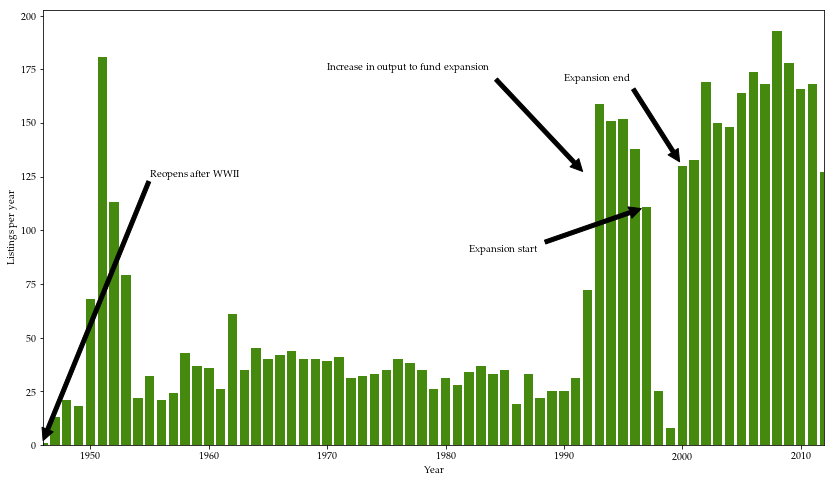

In [51]:
######################## SINGLE THEATRE FOCUS (ROH) ########################

sources = ['Royal Opera House']

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(sources)]
# o_df = o_df[o_df['work'] != 'Unknown']
# o_df = o_df[(o_df['year'] > 1940) & (o_df['year'] < 2013)]
o_df = o_df.groupby(['source_name', 'year'])
o_df = o_df.agg({'performance_count': np.sum })
o_df = o_df.reset_index(level=['year'])

###############################################################

##################### CHART BUILDING OPTIONS #####################

sources = o_df.index.get_level_values('source_name').get_values()
sources = list(set(sources))

fig, ax = plt.subplots(figsize=(14, 8))

for source in sources:
    dat = o_df.loc[source]
#     dates = dat.index
    dates = dat['year'].values
    
    left_edge = dat['year'].values[0]
    right_edge = dat['year'].values[-1]    
    ax.bar(dates, dat['performance_count'], label=source, color='#458a0f', linewidth=3)
    ax.set_xlim(left_edge, right_edge)
    ax.annotate('Reopens after WWII', xy=(1946, 2), xytext=(1955, 125), arrowprops=dict(facecolor='black', shrink=1), )    
    ax.annotate('Increase in output to fund expansion', xy=(1992, 125), xytext=(1970, 175), arrowprops=dict(facecolor='black', shrink=0.05), )                
    ax.annotate('Expansion start', xy=(1997, 111), xytext=(1982, 90), arrowprops=dict(facecolor='black', shrink=0.05), )            
    ax.annotate('Expansion end', xy=(2000, 130), xytext=(1990, 170), arrowprops=dict(facecolor='black', shrink=0.05), )        


plt.xlabel("Year")
plt.ylabel("Listings per year")

ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.grid(False)

###############################################################

In [52]:
######################## top composers ########################


        
sources = archival_sources

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['composer'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']

for num, source in enumerate(sources):
    c_df = o_df[o_df['source_name']==source]
    c_df = c_df.groupby(['composer'])
    c_df = c_df.agg({'performance_count': np.sum })
    c_df = c_df.sort_values(by=['performance_count'], ascending=False)    
    c_df = c_df.head(5)
    c_df = c_df.reset_index(level=['composer'])  
    c_df[source] = c_df['composer']    
    c_df = c_df[source]
    if num==0:
        df = c_df.copy().to_frame()
    else:
        df = df.join(c_df, how='outer')
    
#If displaying sources as columns
# print('\\textbf{Ranking} & \\textbf{' + ' & \\textbf{'.join(df.columns.values.tolist()) + ' \\\ \midrule ')

# for idx,row in df.iterrows():
#     print(str(idx+1) + ' & ' + ' & '.join(row.values.tolist()) + " \\\\")

df = df.T

for idx,row in df.iterrows():
    values = row.values.tolist()
    values = [get_last_name(c) for c in values ]
    print(idx + ' & ' + ' & '.join(values) + " \\\\")
###############################################################

Metropolitan Opera & Verdi & Puccini & Wagner & Mozart & Donizetti \\
Opera Scotland & Mozart & Verdi & Puccini & Rossini & Donizetti \\
Royal Opera House & Verdi & Puccini & Mozart & Wagner & Strauss \\
Teatro alla Scala & Verdi & Puccini & Donizetti & Rossini & Mozart \\
Wiener Staatsoper & Verdi & Mozart & Wagner & Puccini & Strauss \\
Chicago Lyric Opera & Verdi & Puccini & Wagner & Mozart & Donizetti \\
San Francisco Opera & Verdi & Puccini & Wagner & Mozart & Donizetti \\
Czech National Theatre & Smetana & Dvořák & Mozart & Verdi & Puccini \\
Glyndebourne & Mozart & Verdi & Rossini & Strauss & Britten \\
Salzburg Festival & Mozart & Strauss & Verdi & Beethoven & Rossini \\
Sweden Opera House & Verdi & Mozart & Puccini & Wagner & Bizet \\
National Opera de Paris & Verdi & Mozart & Puccini & Rossini & Strauss \\
Opera Comique & Gounod & Donizetti & Offenbach & Isouard & Dalayrac \\


In [65]:
######################## top composers table ########################

sources = archival_sources

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['composer'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']

top_composers = []

for num, source in enumerate(sources):
    c_df = o_df[o_df['source_name']==source]
    c_df = c_df.groupby(['composer'])
    c_df = c_df.agg({'performance_count': np.sum })
    c_df = c_df.sort_values(by=['performance_count'], ascending=False)    
    top = c_df.head(5)
    for composer in list(top.index):
        if composer not in top_composers:
            top_composers.append(composer) 
    c_df = c_df.reset_index(level=['composer'])  
    c_df.index += 1
    c_df = c_df.reset_index() 
    c_df = c_df.rename({'index': source}, axis='columns')
    c_df = c_df.set_index('composer')
    c_df = c_df[[source]]
    if num==0:
        df = c_df.copy()
    else:
        df = df.join(c_df, how='outer')

df = df.reset_index(level=['composer'])  
df = df[df['composer'].isin(top_composers)]  
df = df.fillna(value=0)

decades = df.columns.get_values().tolist()
decades = [str(d) for d in decades[1:]]
o_df = o_df.fillna(value=0)


print('r'*len(decades))
print('\\textbf{Composer} & \\textbf{' + ' & \\textbf{'.join(decades) + ' \\\ \midrule ')

for idx,row in df.iterrows():
    values = row.values.tolist()
    values = [make_dash_zero(c) for c in values[1:] ]
    print(get_last_name(row['composer']) + ' & ' + ' & '.join(values) + " \\\\")

rrrrrrrrrrrrr
\textbf{Composer} & \textbf{Metropolitan Opera & \textbf{Opera Scotland & \textbf{Royal Opera House & \textbf{Teatro alla Scala & \textbf{Wiener Staatsoper & \textbf{Chicago Lyric Opera & \textbf{San Francisco Opera & \textbf{Czech National Theatre & \textbf{Glyndebourne & \textbf{Salzburg Festival & \textbf{Sweden Opera House & \textbf{National Opera de Paris & \textbf{Opera Comique \\ \midrule 
Dvořák & 50 & 43 & 51 & 43 & 88 & - & 73 & 2 & 23 & 55 & - & 35 & - \\
Smetana & 31 & 25 & 27 & - & 13 & 47 & 44 & 1 & 25 & - & 71 & 44 & - \\
Britten & 24 & 7 & 7 & 19 & 49 & 13 & 15 & 58 & 5 & 72 & 33 & 22 & 91 \\
Gounod & 12 & 36 & 15 & 24 & 23 & 9 & 10 & 14 & - & 19 & 9 & 9 & 1 \\
Donizetti & 5 & 5 & 8 & 3 & 7 & 5 & 5 & 23 & 8 & 18 & 8 & 12 & 2 \\
Bizet & 6 & 9 & 9 & 13 & 11 & 8 & 8 & 8 & 14 & 13 & 5 & 10 & 8 \\
Puccini & 2 & 3 & 2 & 2 & 4 & 2 & 2 & 5 & 6 & 20 & 3 & 3 & 23 \\
Rossini & 7 & 4 & 6 & 4 & 9 & 7 & 7 & 10 & 3 & 5 & 6 & 4 & 11 \\
Verdi & 1 & 2 & 1 & 1 & 1 & 1 & 1 & 

In [57]:
# df

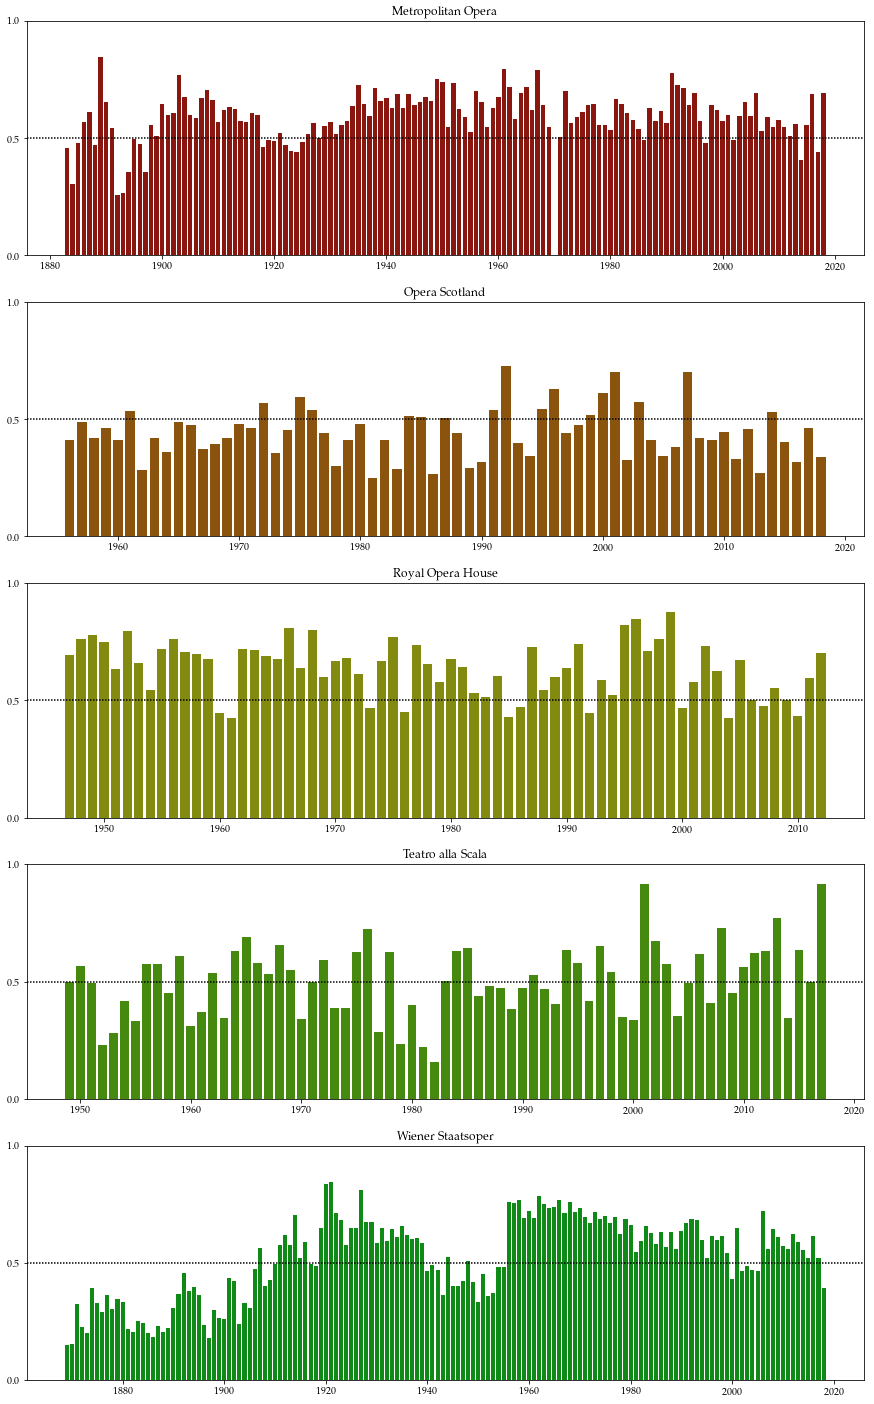

In [22]:
#################### top composers share of repertoire ####################

sources = archival_sources
num_sources = len(sources)

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['work'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']
o_df = o_df[o_df['year'] < 2019]

for source in sources:
    dat = o_df[o_df['source_name']==source]
    c_df = dat.groupby(['composer'])
    c_df = c_df.agg({'performance_count': np.sum })
    top_composers = list(c_df.sort_values(by=['performance_count'], ascending=False).index.values[0:5])    
    o_df['composer'] = o_df.apply(lambda row: label_top(row['source_name'], source, row['composer'], top_composers), axis=1)
    
c_df = o_df.groupby(['source_name', 'year', 'composer']).agg({'performance_count': np.sum })
c_df = c_df.groupby(level = ['source_name', 'year']).transform(lambda x: x/x.sum())
c_df = c_df.reset_index(level=['year', 'composer'])

fig = plt.figure(figsize=(15, 25))

for num, source in enumerate(sources):
    
    dat = c_df.loc[source]
    dat = dat[dat['composer']=='Top']
    dates = dat['year'].values

    ax = plt.subplot(num_sources, 1, num + 1)
    plt.bar(dates, dat['performance_count'], label=source, color=colors[num], linewidth=3)
    ax.set_title(source)
    
    axes = plt.gca()
    axes.set_ylim([0,1])
    axes.axhline(y=.5, dashes=[1, 1], color='#000000')
    axes.yaxis.set_major_locator(ticker.MultipleLocator(0.5))

# plt.tight_layout()

###############################################################

In [93]:
######################## top works table ########################

sources = archival_sources

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['composer'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']

for num, source in enumerate(sources):
    c_df = o_df[o_df['source_name']==source]
    c_df = c_df.groupby(['work'])
    c_df = c_df.agg({'performance_count': np.sum })
    c_df = c_df.sort_values(by=['performance_count'], ascending=False)    
    c_df = c_df.head(10)
    c_df = c_df.reset_index(level=['work'])  
    c_df[source] = c_df['work']    
    c_df = c_df[source]
    if num==0:
        df = c_df.copy().to_frame()
    else:
        df = df.join(c_df, how='outer')
    
df = df.T

works_dict = {
    'La bohème': 'La bohème',
    'Aida': 'Aida',
    'Carmen': 'Carmen',
    'Tosca': 'Tosca',
    'La traviata': 'Traviata',
    'Rigoletto': 'Rigoletto',    
    'Madama Butterfly': 'Butterfly',
    'La damnation de Faust': 'Faust',
    'Il trovatore': 'Il trovatore',
    'The Barber of Seville': 'The Barber of S.',
    'The Marriage of Figaro': 'M. Figaro',
    'The Magic Flute': 'M. Flute',
    'Così fan tutte': 'Così',
    'Don Giovanni': 'Don Giovanni',
    'Turandot': 'Turandot',
    'Der Rosenkavalier': 'Der Rosenkavalier',
    'The Enchanted Island': 'The E. Island',
     "L'elisir d'amore":  "L'elisir",
    'Cavalleria rusticana': 'Cavalleria',
    'Les Huguenots': 'Les Huguenots',
    'The Flying Dutchman': 'The F. Dutchman',
    'Fidelio': 'Fidelio'
}

for idx,row in df.iterrows():
    values = row.values.tolist()
    values = [works_dict[c] for c in values ]
    print(idx + ' & ' + ' & '.join(values) + " \\\\")
    
###############################################################

Metropolitan Opera & La bohème & Aida & Carmen & Traviata & Tosca & Rigoletto & Butterfly & Faust & Il trovatore & The Barber of S. \\
Opera Scotland & La bohème & M. Figaro & Traviata & M. Flute & Butterfly & Così & Don Giovanni & Carmen & The Barber of S. & Tosca \\
Royal Opera House & Tosca & La bohème & Traviata & Turandot & Rigoletto & M. Figaro & Aida & M. Flute & Butterfly & Der Rosenkavalier \\
Teatro alla Scala & La bohème & Butterfly & Aida & Rigoletto & The E. Island & The Barber of S. & Tosca & L'elisir & Turandot & Cavalleria \\
Wiener Staatsoper & Tosca & M. Figaro & M. Flute & Der Rosenkavalier & Les Huguenots & Aida & The F. Dutchman & La bohème & Il trovatore & Fidelio \\


In [73]:
######################## Composer works in theatre chart ########################

o_df = mdf.copy()
o_df = o_df[o_df['source_name']=='Wiener Staatsoper']
o_df = o_df[o_df['composer'] == 'Albert Lortzing']

works = list(o_df['work'].unique())
num_works = len(works)

o_df = o_df.groupby(['work', 'decade'])
o_df = o_df.agg({'performance_count': np.sum })
o_df = o_df.reset_index(level=['work', 'decade'])

o_df = o_df.pivot(index='work', columns='decade', values=['performance_count'])
o_df = o_df.fillna(value=0)

decades = o_df.columns.get_level_values(1).get_values().tolist()
decades = [str(d) for d in decades]

print('r'*len(decades))
print('\\textbf{Opera} & \\textbf{' + ' & \\textbf{'.join(decades) + ' \\\ \midrule ')

for idx,row in o_df.iterrows():
    values = row.values.tolist()
    values = [make_dash_zero(c) for c in values ]
    print(idx + ' & ' + ' & '.join(values) + " \\\\")

rrrrrrrrrr
\textbf{Opera} & \textbf{1870 & \textbf{1880 & \textbf{1890 & \textbf{1900 & \textbf{1910 & \textbf{1920 & \textbf{1930 & \textbf{1940 & \textbf{1950 & \textbf{1960 \\ \midrule 
Der Waffenschmied & 8 & 15 & 12 & 7 & 12 & - & 10 & 62 & 21 & - \\
Der Wildschütz & - & 9 & 9 & 8 & 3 & - & 4 & - & 21 & 14 \\
Die Opernprobe & - & - & 13 & 12 & - & - & - & - & - & - \\
Die beiden Schützen & - & 5 & 2 & - & - & - & - & - & - & - \\
Zar und Zimmermann & 2 & 4 & 16 & 14 & 13 & 4 & 9 & - & - & - \\


In [28]:
######################## Composer works in theatre chart ########################

o_df = mdf.copy()
o_df = o_df[o_df['source_name']=='Wiener Staatsoper']
o_df = o_df[o_df['composer'] == 'Albert Lortzing']

works = list(o_df['work'].unique())
num_works = len(works)

o_df = o_df.groupby(['work', 'decade'])
o_df = o_df.agg({'performance_count': np.sum })
o_df = o_df.reset_index(level=['work', 'decade'])

o_df = o_df.pivot(index='work', columns='decade', values=['performance_count'])
o_df = o_df.fillna(value=0)

decades = o_df.columns.get_level_values(1).get_values().tolist()
decades = [str(d) for d in decades]

print('r'*len(decades))
print('\\textbf{Opera} & \\textbf{' + ' & \\textbf{'.join(decades) + ' \\\ \midrule ')

for idx,row in o_df.iterrows():
    values = row.values.tolist()
    values = [make_dash_zero(c) for c in values ]
    print(idx + ' & ' + ' & '.join(values) + " \\\\")

rrrrrrrrrr
\textbf{Opera} & \textbf{1870 & \textbf{1880 & \textbf{1890 & \textbf{1900 & \textbf{1910 & \textbf{1920 & \textbf{1930 & \textbf{1940 & \textbf{1950 & \textbf{1960 \\ \midrule 
Der Waffenschmied & 8 & 15 & 12 & 7 & 12 & - & 10 & 62 & 21 & - \\
Der Wildschütz & - & 9 & 9 & 8 & 3 & - & 4 & - & 21 & 14 \\
Die Opernprobe & - & - & 13 & 12 & - & - & - & - & - & - \\
Die beiden Schützen & - & 5 & 2 & - & - & - & - & - & - & - \\
Zar und Zimmermann & 2 & 4 & 16 & 14 & 13 & 4 & 9 & - & - & - \\


In [67]:
######################## top composers over decades ########################
print(archival_sources)
o_df = mdf.copy()
o_df = o_df[o_df['source_name']=='Sweden Opera House']
o_df = o_df[o_df['composer'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']

decades = list(o_df['decade'].unique())
decades.sort()

top_composers = []

for num, decade in enumerate(decades):
    c_df = o_df[o_df['decade']==decade]
    c_df = c_df.groupby(['composer'])
    c_df = c_df.agg({'performance_count': np.sum })
    c_df = c_df.sort_values(by=['performance_count'], ascending=False)    
    top = c_df.head(5)
#     print(top)
    for composer in list(top.index):
        if composer not in top_composers:
            top_composers.append(composer) 
    c_df = c_df.reset_index(level=['composer'])  
    c_df.index += 1
    c_df = c_df.reset_index() 
    c_df = c_df.rename({'index': decade}, axis='columns')
    c_df = c_df.set_index('composer')
    c_df = c_df[[decade]]
    if num==0:
        df = c_df.copy()
    else:
        df = df.join(c_df, how='outer')
        
df = df.reset_index(level=['composer'])  
df = df[df['composer'].isin(top_composers)] 
df.loc[df['composer']=='Franz Lehár', 'composer'] = 'Franz Lehar'
df = df.sort_values(by=[decades[-1]], na_position='last')    

# print(df)


fig = plt.figure(figsize=(17, 10))
pd.plotting.parallel_coordinates(df, 'composer', colormap='Dark2', linewidth=2)#, color=color, 
plt.gca().get_lines()[8].set_color("black")
plt.gca().get_lines()[8].set_dashes([4,4])
plt.gca().get_lines()[9].set_color("black")
plt.gca().get_lines()[9].set_dashes([2,1,2,1])
plt.gca().get_lines()[10].set_color("black")
plt.gca().get_lines()[10].set_dashes([1,1])

from scipy.stats import loglaplace,chi2
from labellines import labelLine, labelLines

labelLines(plt.gca().get_lines())

ax = plt.gca()
ax.invert_yaxis()

ax.yaxis.grid(False)
# plt.yticks(np.arange(1, 35, 1.0))
plt.yticks(np.arange(1, 35, 2.0))
plt.legend(loc=(.82,0))    

['Metropolitan Opera', 'Opera Scotland', 'Royal Opera House', 'Teatro alla Scala', 'Wiener Staatsoper', 'Chicago Lyric Opera', 'San Francisco Opera', 'Czech National Theatre', 'Glyndebourne', 'Salzburg Festival', 'Sweden Opera House', 'National Opera de Paris', 'Opera Comique']


UnicodeEncodeError: 'ascii' codec can't encode character '\xe9' in position 253: ordinal not in range(128)

(array([ 1880.,  1890.,  1900.,  1910.,  1920.,  1930.,  1940.,  1950.,
         1960.,  1970.,  1980.,  1990.,  2000.,  2010.,  2020.]),
 <a list of 15 Text xticklabel objects>)

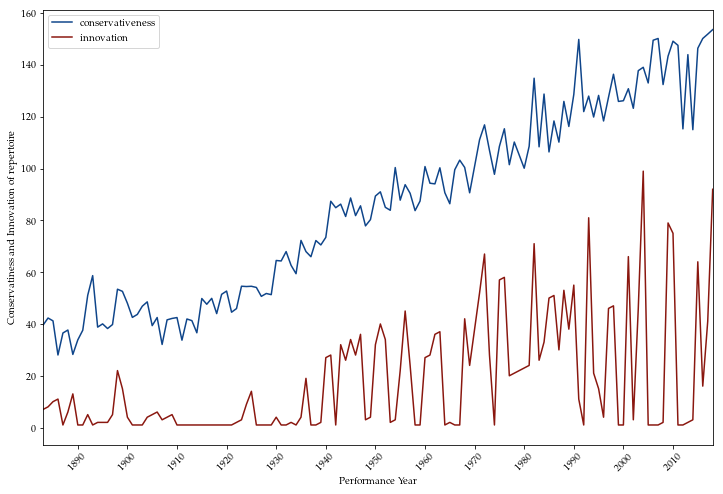

In [5]:
######################## conservativeness  ########################

sources = archival_sources
sources = ['Metropolitan Opera']

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['work_decade']!=0]

o_df['total_age_works'] = o_df.apply(lambda row: row['performance_count']*(row['year']-row['premiere_date']), axis=1)

# o_df[o_df['year']==1883].sort_values(by=['premiere_date'])

c_df = o_df.groupby(['year'])
c_df = c_df.agg({'total_age_works': np.sum, 'performance_count': 'sum', 'premiere_date': np.max })
c_df['conservativeness'] = c_df.apply(lambda row: row['total_age_works']/row['performance_count'], axis=1)
c_df['innovation'] = c_df.apply(lambda row: max(row.name - row['premiere_date'], 1), axis=1)
c_df = c_df[['conservativeness', 'innovation']]

left_edge = c_df.index[0]
right_edge = c_df.index[-1]

c_df.plot(figsize=(12, 8), color=list(np.array(colors)[[7,0]]))
plt.ylabel('Conservatiness and Innovation of repertoire')
plt.xlabel('Performance Year')
ax = plt.gca()
# # ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlim(left_edge, right_edge)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.xticks(rotation=45)

In [6]:
######################## conservativeness and innovation ########################
sources = archival_sources
# sources = ['Metropolitan Opera']

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['work_decade']!=0]
o_df = o_df[o_df['year']<2019]

o_df['total_age_works'] = o_df.apply(lambda row: row['performance_count']*(row['year']-row['premiere_date']), axis=1)

for source in sources:
    c_df = o_df[o_df['source_name']==source]
    c_df = c_df.groupby(['decade'])
    c_df = c_df.agg({'total_age_works': np.sum, 'performance_count': 'sum', 'premiere_date': np.max })
    c_df['conservativeness'] = c_df.apply(lambda row: row['total_age_works']/row['performance_count'], axis=1)
    c_df['innovation'] = c_df.apply(lambda row: max(row.name - row['premiere_date'], 0), axis=1)
    c_df = c_df[['conservativeness', 'innovation']]
    print(source)
    print('-----')    
    for idx,row in c_df.iterrows():
        values = row.values.tolist()
        values = [str(int(c)) for c in values ]
        print(str(idx) + ' & ' + ' & '.join(values) + " \\\\")
    print('-----')    

Metropolitan Opera
-----
1880 & 35 & 0 \\
1890 & 43 & 0 \\
1900 & 42 & 0 \\
1910 & 43 & 0 \\
1920 & 51 & 0 \\
1930 & 66 & 0 \\
1940 & 82 & 0 \\
1950 & 89 & 0 \\
1960 & 96 & 0 \\
1970 & 108 & 0 \\
1980 & 116 & 23 \\
1990 & 128 & 0 \\
2000 & 136 & 0 \\
2010 & 139 & 0 \\
-----
Opera Scotland
-----
1950 & 93 & 0 \\
1960 & 104 & 0 \\
1970 & 123 & 0 \\
1980 & 121 & 0 \\
1990 & 133 & 0 \\
2000 & 138 & 0 \\
2010 & 149 & 0 \\
-----
Royal Opera House
-----
1940 & 84 & 0 \\
1950 & 84 & 0 \\
1960 & 87 & 0 \\
1970 & 97 & 0 \\
1980 & 113 & 0 \\
1990 & 128 & 0 \\
2000 & 132 & 0 \\
2010 & 149 & 0 \\
-----
Teatro alla Scala
-----
1940 & 64 & 44 \\
1950 & 101 & 0 \\
1960 & 101 & 0 \\
1970 & 125 & 0 \\
1980 & 114 & 0 \\
1990 & 139 & 9 \\
2000 & 131 & 0 \\
2010 & 153 & 0 \\
-----
Wiener Staatsoper
-----
1860 & 40 & 7 \\
1870 & 28 & 0 \\
1880 & 39 & 0 \\
1890 & 40 & 0 \\
1900 & 46 & 0 \\
1910 & 43 & 0 \\
1920 & 48 & 0 \\
1930 & 56 & 0 \\
1940 & 78 & 0 \\
1950 & 93 & 0 \\
1960 & 107 & 3 \\
1970 & 111 & 0 \\

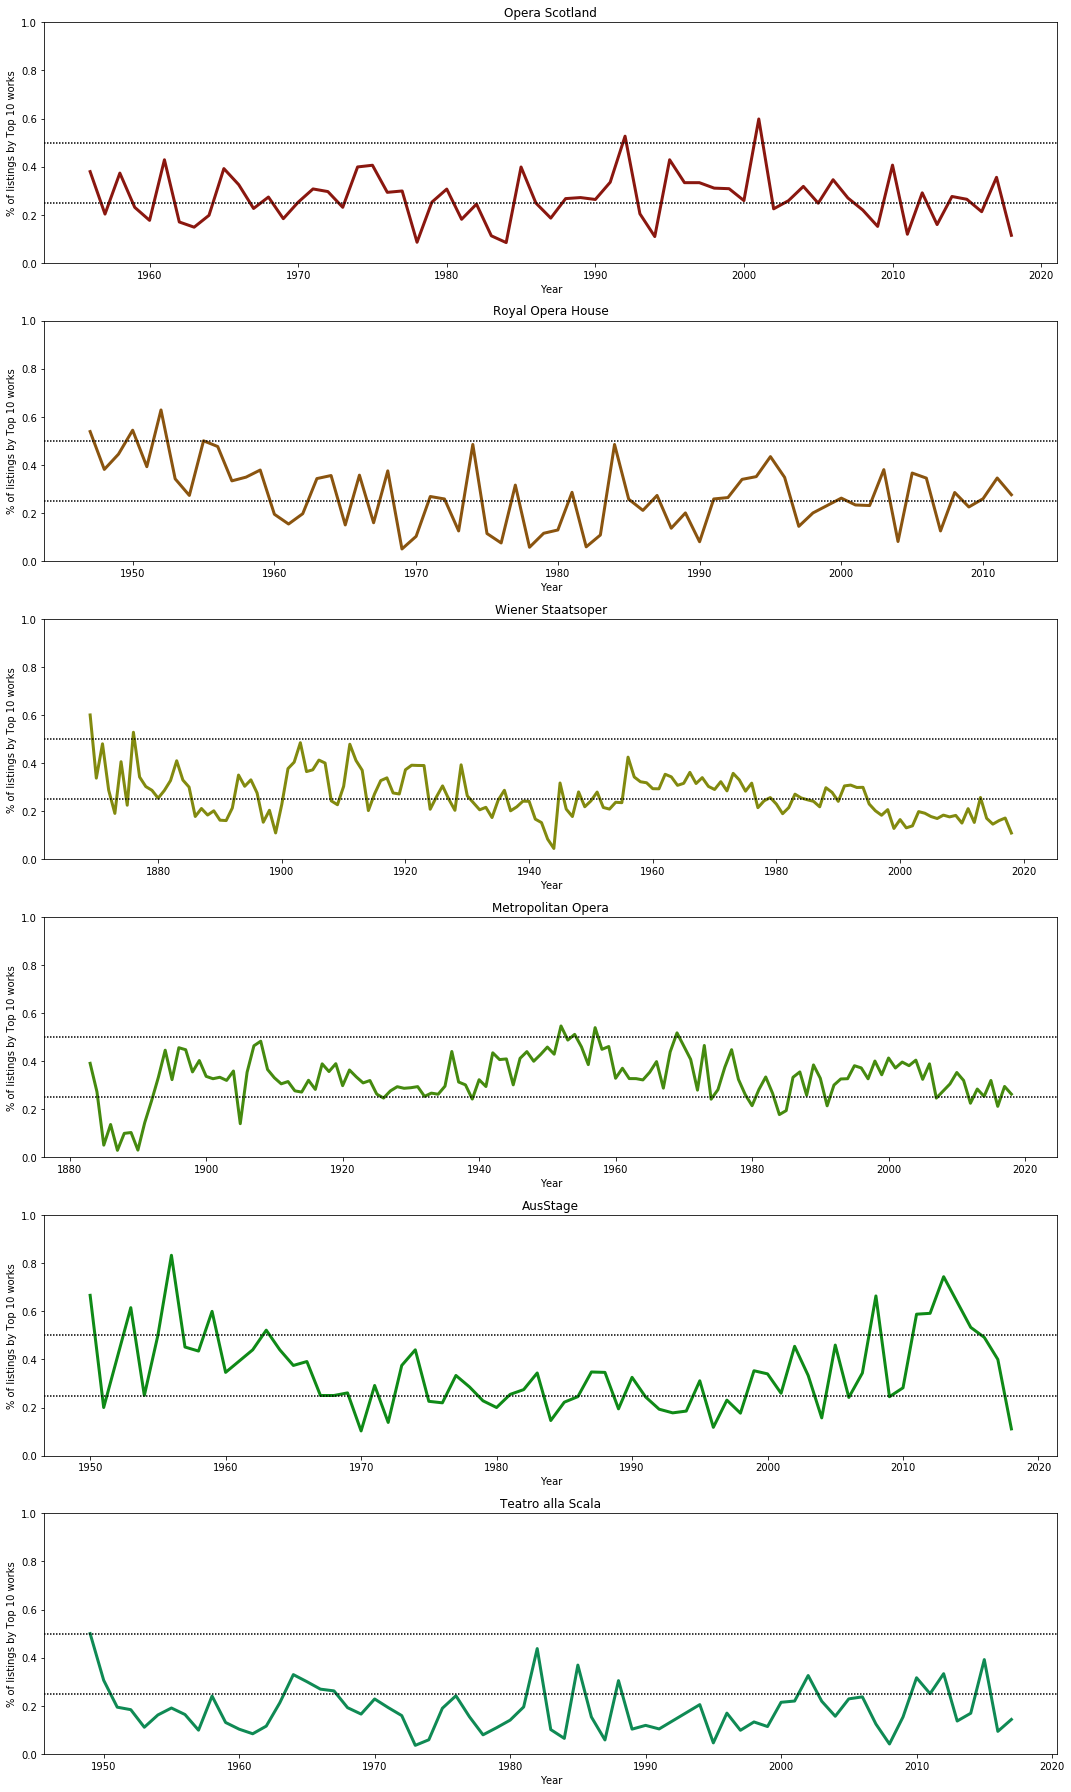

In [6]:
######################## top works ########################

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

def label_top(source, target_source, value, top_values):
    if source == target_source:
        if value in top_values:
            return 'Top'
        else:
            return 'Other'
    else:
        return value
        
archival_sources = ['AusStage', 'Metropolitan Opera', 'Opera Scotland', 'Royal Opera House', 'Teatro alla Scala', 'Wiener Staatsoper']
commercial_sources = ['Concert-Diary','U.K. Theatre Web','bachtrack.com','operabase.com','operacritic.com']
government_sources = ['National Central Opera Service Reports', 'Opera America']

sources = archival_sources
colors = ['#8a170f', '#8a540f', '#828a0f', '#458a0f', '#0f8a17', '#0f8a54', '#0f828a', '#0f458a', '#170f8a', '#540f8a', '#8a0f82', '#8a0f45']

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['work'] != 'Unknown']
o_df = o_df[o_df['work'] != '']
# o_df = o_df[o_df['year'] > 1999]
o_df = o_df[o_df['year'] < 2019]

for source in sources:
    dat = o_df[o_df['source_name']==source]
    c_df = dat.groupby(['work'])
    c_df = c_df.agg({'performance_count': np.sum })
    top_works = list(c_df.sort_values(by=['performance_count'], ascending=False).index.values[0:10])    
    o_df['work'] = o_df.apply(lambda row: label_top(row['source_name'], source, row['work'], top_works), axis=1)
    
c_df = o_df.groupby(['source_name', 'year', 'work']).agg({'performance_count': np.sum })
c_df = c_df.groupby(level = ['source_name', 'year']).transform(lambda x: x/x.sum())

c_df = c_df.reset_index(level=['year', 'work'])

sources = c_df.index.get_level_values('source_name').get_values()
sources = list(set(sources))
num_sources = len(sources)

fig = plt.figure(figsize=(15, 25))

for num, source in enumerate(sources):
    
    dat = c_df.loc[source]    
    dat = dat[dat['work']=='Top']
    dates = dat['year'].values

    ax = plt.subplot(num_sources, 1, num + 1)
    plt.plot(dates, dat['performance_count'], label=source, color=colors[num], linewidth=3)
    plt.xlabel("Year")
    plt.ylabel("% of listings by Top 10 works")
    ax.set_title(source)
    
    axes = plt.gca()
    axes.set_ylim([0,1])
    axes.axhline(y=.5, dashes=[1, 1], color='#000000')
    axes.axhline(y=.25, dashes=[1, 1], color='#000000')    

plt.tight_layout()

###############################################################

(array([ 1500.,  1600.,  1700.,  1800.,  1900.,  2000.,  2100.]),
 <a list of 7 Text xticklabel objects>)

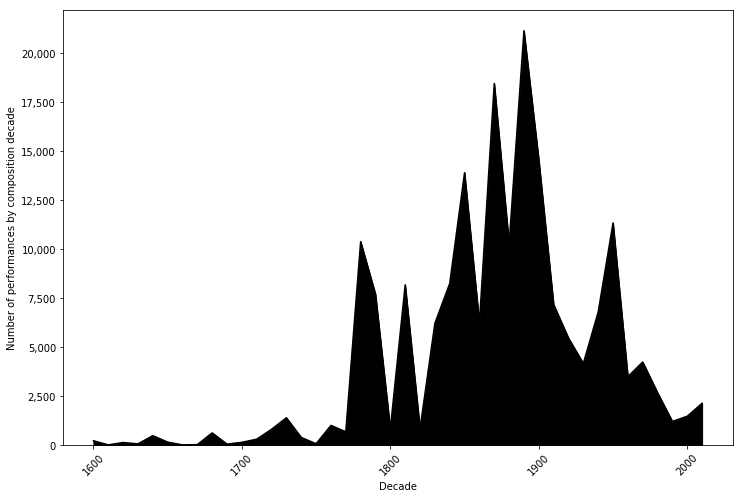

In [467]:
%matplotlib inline

######################## top composers chart ########################

import sys
sys.path.append('../../')

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

from utils.utility_functions import label_top
        
archival_sources = ['AusStage', 'Metropolitan Opera', 'Opera Scotland', 'Royal Opera House', 'Teatro alla Scala', 'Wiener Staatsoper']
commercial_sources = ['Concert-Diary','U.K. Theatre Web','bachtrack.com','operabase.com','operacritic.com']
government_sources = ['National Central Opera Service Reports', 'Opera America']

sources = government_sources
colors = ['#8a170f', '#8a540f', '#828a0f', '#458a0f', '#0f8a17', '#0f8a54', '#0f828a', '#0f458a', '#170f8a', '#540f8a', '#8a0f82', '#8a0f45']

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['composer'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']
o_df = o_df[o_df['work_decade']!=0]

decades_dict = { 'work_decade': np.arange(1600, 2020, 10), 'zeros': np.zeros(42) }
d_df = pd.DataFrame.from_dict(decades_dict)
d_df = d_df.set_index('work_decade')

c_df = o_df.groupby(['work_decade'])
c_df = c_df.agg({'performance_count': np.sum })
c_df = c_df.sort_values(by=['performance_count'], ascending=False)    
c_df = c_df.sort_index()

c_df = c_df.join(d_df, how='outer')
c_df['performance_count'] = c_df['performance_count'].fillna(value=0)
c_df = c_df[['performance_count']]

c_df.plot.area(color='#000000', figsize=(12, 8), legend=False)
plt.ylabel('Number of performances by composition decade')
plt.xlabel('Decade')
ax = plt.gca()
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=45)

# plt.plot(df['Year'], df['performance_count'], '-o', color='orange')


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: 'work_decade' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


(array([ 1400.,  1500.,  1600.,  1700.,  1800.,  1900.,  2000.,  2100.]),
 <a list of 8 Text xticklabel objects>)

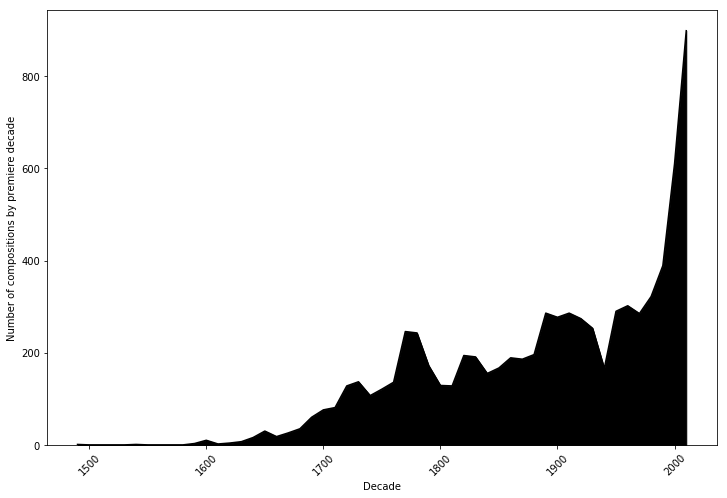

In [468]:
%matplotlib inline

######################## works premieres ########################
import sys
sys.path.append('../../')

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import pandas as pd

from utils.utility_functions import label_top

columns=['work', 'premiere_date']

cursor = conn.cursor()  
query = "SELECT w.name, " + \
        "       w.premiere_date " + \
        "from works w "
        
cursor.execute(query)

wdf = pd.DataFrame(cursor.fetchall(), columns=columns)
wdf[['premiere_date']] = wdf[['premiere_date']].fillna(value=0)
wdf['work_decade'] = wdf.apply(lambda row: 10*int(row['premiere_date']/10), axis=1)
    
o_df = wdf.copy()
o_df = o_df[o_df['work_decade']!=0]

decades_dict = { 'work_decade': np.arange(1490, 2020, 10), 'zeros': np.zeros(len(np.arange(1490, 2020, 10))) }
d_df = pd.DataFrame.from_dict(decades_dict)
d_df = d_df.set_index('work_decade')

c_df = o_df.groupby(['work_decade'])
c_df = c_df.agg({'work_decade': 'count' })
c_df = c_df.sort_values(by=['work_decade'], ascending=False)    
c_df = c_df.sort_index()

c_df = c_df.join(d_df, how='outer')
c_df['works_count'] = c_df['work_decade'].fillna(value=0)
c_df = c_df[['work_decade']]

c_df.plot.area(color='#000000', figsize=(12, 8), legend=False)
plt.ylabel('Number of compositions by premiere decade')
plt.xlabel('Decade')
ax = plt.gca()
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=45)

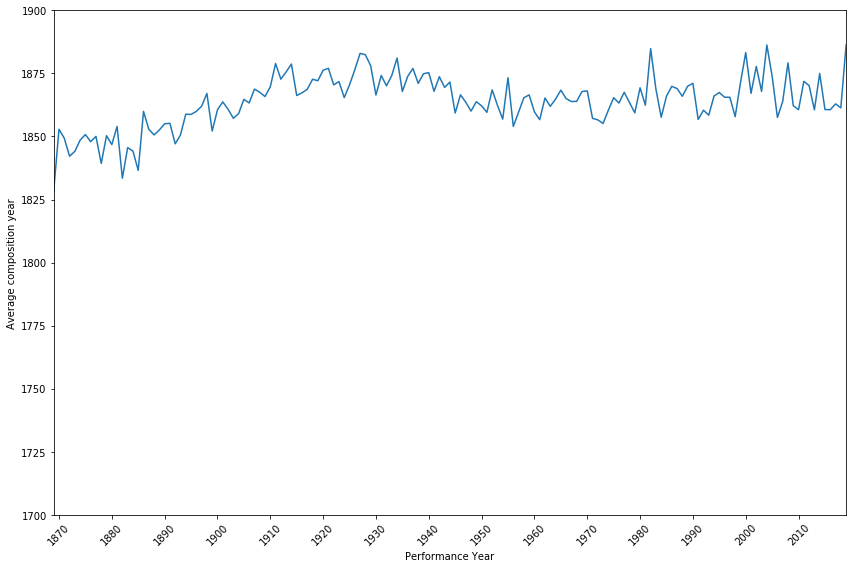

In [481]:
%matplotlib inline

######################## works premieres ########################
import sys
sys.path.append('../../')

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker

from utils.utility_functions import label_top
    
    
archival_sources = ['AusStage', 'Metropolitan Opera', 'Opera Scotland', 'Royal Opera House', 'Teatro alla Scala', 'Wiener Staatsoper']
commercial_sources = ['Concert-Diary','U.K. Theatre Web','bachtrack.com','operabase.com','operacritic.com']
government_sources = ['National Central Opera Service Reports', 'Opera America']

sources = archival_sources

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['work_decade']!=0]


o_df['aggregate_year'] = o_df.apply(lambda row: row['performance_count']*row['premiere_date'], axis=1)

c_df = o_df.groupby(['year'])
c_df = c_df.agg({'aggregate_year': np.sum, 'work': 'count' })
c_df['average_premiere_year'] = c_df.apply(lambda row: row['aggregate_year']/row['work'], axis=1)
c_df = c_df[['average_premiere_year']]
left_edge = c_df.index[0]
right_edge = c_df.index[-1]

c_df.plot.line(figsize=(12, 8), legend=False)

plt.ylabel('Average composition year')
plt.xlabel('Performance Year')
ax = plt.gca()
ax.set_ylim([1700,1900])
ax.set_xlim(left_edge, right_edge)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

# ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=45)
plt.tight_layout()

In [477]:
c_df.index[0]

1869

In [17]:
# o_df.columns
o_df.columns.get_level_values(1).get_values()


array([1860, 1870, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960,
       1970, 1980, 1990, 2000, 2010])

IndexError: list index out of range

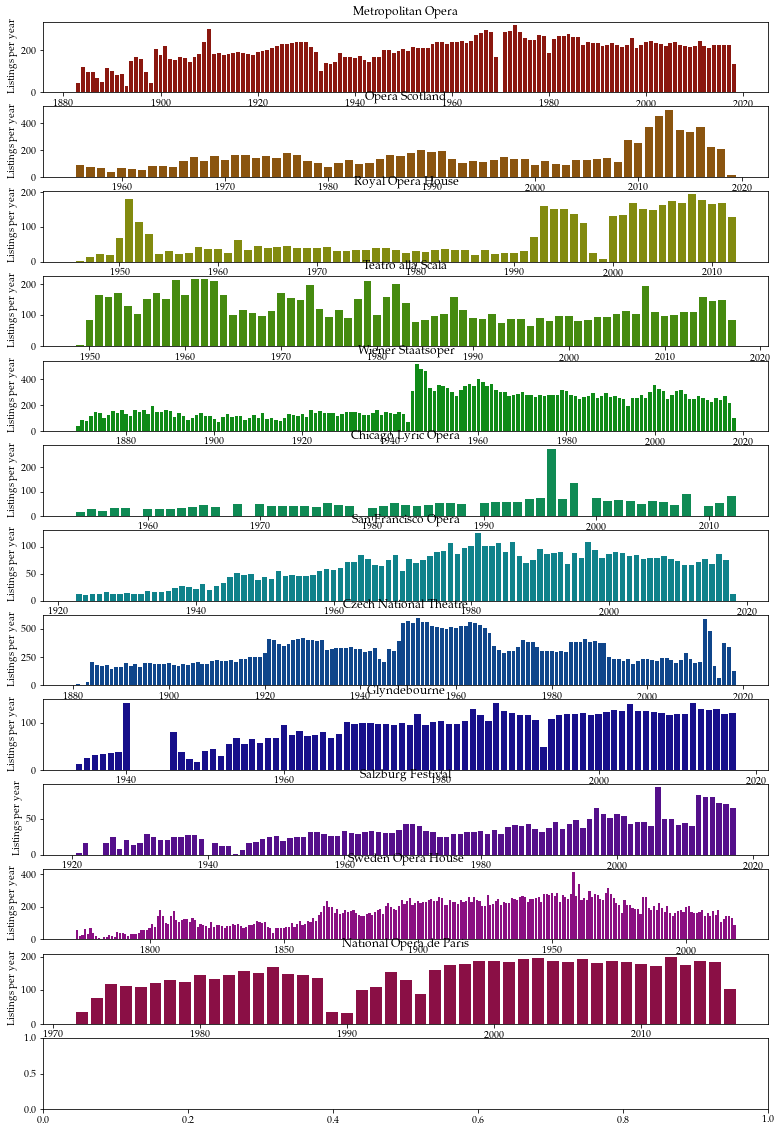

In [61]:
##################### DATA FILTER OPTIONS #####################

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(archival_sources)]
o_df = o_df[o_df['work'] != 'Unknown']
# o_df = o_df[(o_df['year'] > 1940) & (o_df['year'] < 2010)]
o_df = o_df.groupby(['source_name', 'year'])
o_df = o_df.agg({'performance_count': np.sum })
o_df = o_df.reset_index(level=['year'])

###############################################################

##################### CHART BUILDING OPTIONS #####################

sources = archival_sources
num_sources = len(sources)

fig = plt.figure(figsize=(13, 20))

for num, source in enumerate(sources):
    
    dat = o_df.loc[source]    
    dates = dat['year'].values

    ax = plt.subplot(num_sources, 1, num + 1)
    plt.bar(dates, dat['performance_count'], label=source, color=colors[num], linewidth=3)
    plt.xlabel("Year")
    plt.ylabel("Listings per year")
    ax.set_title(source)

plt.tight_layout()

###############################################################

In [182]:
list(np.array(colors)[[0,7]])

['#8a170f', '#0f458a']

In [24]:
######################## top composers ########################
sources = ['Royal Opera House']

# archival_sources = ['Metropolitan Opera', 'Opera Scotland', 'Royal Opera House', 'Teatro alla Scala', 'Wiener Staatsoper']


o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['composer'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']


c_df = o_df.groupby(['composer'])
c_df = c_df.agg({'performance_count': np.sum })
c_df = c_df.sort_values(by=['performance_count'], ascending=False)    
c_df = c_df.reset_index(level=['composer'])

c_df['perc']= 100*c_df['performance_count']/c_df['performance_count'].sum()
c_df['perc_sq'] = c_df['perc']**2

c_df['perc_sq'].values.sum()
###############################################################

921.97682329474424

In [8]:
c_df.head()

,performance_count
composer,
Giuseppe Verdi,13765
Giacomo Puccini,9480
Richard Wagner,7768
Wolfgang Amadeus Mozart,7560
Richard Strauss,4254


In [53]:
######################## top composers chart ########################

sources = archival_sources

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['composer'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']

top_composers = []

for num, source in enumerate(sources):
    c_df = o_df[o_df['source_name']==source]
    c_df = c_df.groupby(['composer'])
    c_df = c_df.agg({'performance_count': np.sum })
    c_df = c_df.sort_values(by=['performance_count'], ascending=False)    
    top = c_df.head(5)
    for composer in list(top.index):
        if composer not in top_composers:
            top_composers.append(composer) 
    c_df = c_df.reset_index(level=['composer'])  
    c_df.index += 1
    c_df = c_df.reset_index() 
    c_df = c_df.rename({'index': source}, axis='columns')
    c_df = c_df.set_index('composer')
    c_df = c_df[[source]]
    if num==0:
        df = c_df.copy()
    else:
        df = df.join(c_df, how='outer')

df = df.reset_index(level=['composer'])  
df = df[df['composer'].isin(top_composers)]  

fig = plt.figure(figsize=(17, 10))
# plt.title('Composer ranking for in each source')
plt.ylabel("Ranking of composer in theatre")
pd.plotting.parallel_coordinates(df, 'composer', color=colors, linewidth=3)

ax = plt.gca()
ax.invert_yaxis()

ax.yaxis.grid(False)
plt.yticks(np.arange(1, 14, 1.0))

plt.legend(loc=(0,0))


UnicodeEncodeError: 'ascii' codec can't encode character '\xed' in position 254: ordinal not in range(128)